# 1 IMPORTS

In [99]:
import math
import random
import pickle
import inflection
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


from boruta import BorutaPy
from tabulate import tabulate
from IPython.display import Image
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.weightstats import DescrStatsW
from pycorrcat.pycorrcat import plot_corr, corr_matrix
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# warnings.filterwarnings( 'ignore' )

## 1.1 Definitions 

In [100]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

# Extract the year of the first sell of a particular store
def first_sell_year(x):
    if math.isnan(x['competition_open_since_year']):
        store = x['store']
        year = df_ross[df_ross['store'] == store]['date'].min().year
        return year
    else:
        return x['competition_open_since_year']

# Extract the month of the first sell of a particular store
def first_sell_month(x):
    if math.isnan(x['competition_open_since_month']):
        store = x['store']
        month = df_ross[df_ross['store'] == store]['date'].min().month
        return month
    else:
        return x['competition_open_since_month']

# Fixing wrong year inputs    
def year_correction(x):
    if x['competition_open_since_year'] < 1972: # Rossmann foundation year
        store = x['store']
        year = df_ross[df_ross['store'] == store]['date'].min().year
        return year
    else:
        return x['competition_open_since_year']

# Calculating error metrics of the models    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

# Cross Validation Technique
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

## 1.2 Loading Data

In [101]:
sales_raw = pd.read_csv('data/train.csv', low_memory=False, parse_dates=['Date'])
store_raw = pd.read_csv('data/store.csv', low_memory=False)
df_ross = pd.merge(sales_raw, store_raw, how='left', on='Store')

# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_ross.columns ) )
df_ross.columns = cols_snake

# 2 DATA DESCRIPTION

## 2.1 Data Preview

In [102]:
df_ross.head(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## 2.2 Data Format and Types

In [103]:
df_ross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 2.3 NA Checking and Treatment

In [104]:
df_ross.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [105]:
# ===================================================================================
# COMMENTED BECAUSE IT TAKES A WHILE TO RUN AND ITS OUTPUT WAS SAVED IN A .CSV FILE
# ===================================================================================

# # competition_distance
# """ There are only 3 stores with NA competition_distance (291, 622, 879). If we drop the NA values, we will be
# excluding these stores from our dataset. Since we cannot estimate this distance using interpolation or linear regression,
# we are filling these NA values with a value 5x higher than the maximum competition distance in this dataset,
# in order to simulate a very far competitor."""

# max_distance_in_df = df_ross['competition_distance'].max()
# df_ross['competition_distance'].fillna(value=max_distance_in_df * 5, inplace=True)

# # competition_open_since_month and competition_open_since_year
# """ For all NA values in this feature we have a competitor_distance associated with it. So, we are dealing with a 
# missing data, since there is a competitor nearby. To fill these NA values we will consider the data of the first 
# sell on each store."""

# df_ross['competition_open_since_year'] = df_ross.apply(first_sell_year, axis=1)
# df_ross['competition_open_since_month'] = df_ross.apply(first_sell_month, axis=1)

# # # promo2_since_year and promo2_since_week 
# """ Following the same strategy we took in competition_distance, we will set a far away date to the promo2_since, 
# in order to simulate that a store did not participate in promo2."""
# df_ross['promo2_since_year'].fillna(2050, inplace=True ) 
# df_ross['promo2_since_week'].fillna(1, inplace=True )

# # promo_interval 
# df_ross['promo_interval'].fillna(0, inplace=True )

# df_ross.to_csv('data/df_ross_clean.csv', index=False)

In [106]:
df_ross = pd.read_csv('data/df_ross_clean.csv', low_memory=False, parse_dates=['date'])
df_ross.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 2.4 Changing Types

In [107]:
# Changing from float to int
df_ross['competition_open_since_month'] = df_ross['competition_open_since_month'].astype( int )
df_ross['competition_open_since_year'] = df_ross['competition_open_since_year'].astype( int )
    
df_ross['promo2_since_week'] = df_ross['promo2_since_week'].astype( int ) 
df_ross['promo2_since_year'] = df_ross['promo2_since_year'].astype( int )

## 2.5 Discriptive Statistics

### Numerical Attributes

**1.** The value 1900 of competition_open_since_year is innacurate. Since Rossmann was founded in 1972, there is no way of existing a competition in 1900. We will treat this error later on.

**2.** The high values of kurtosis in competition_distance and competition_open_since_year tells us that the distribution have a huge peak in a given values.

In [108]:
num_att = df_ross.select_dtypes(['int64', 'float64', 'int32'])

In [109]:
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = df_ross.describe().round(2)
m = pd.concat([describe, skew, kurtosis], axis=0)
m.iloc[:,1:]

,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.0,1017209.00,1017209.00
mean,4.00,5773.82,633.15,0.83,0.38,0.18,6401.14,5.24,2010.06,0.5,12.15,2030.85
std,2.00,3849.93,464.41,0.38,0.49,0.38,20529.90,3.93,5.34,0.5,14.95,19.16
min,1.00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.0,1.00,2009.00
25%,2.00,3727.00,405.00,1.00,0.00,0.00,710.00,1.00,2008.00,0.0,1.00,2012.00
50%,4.00,5744.00,609.00,1.00,0.00,0.00,2330.00,4.00,2012.00,1.0,1.00,2015.00
75%,6.00,7856.00,837.00,1.00,1.00,0.00,6910.00,9.00,2013.00,1.0,22.00,2050.00
max,7.00,41551.00,7388.00,1.00,1.00,1.00,379300.00,12.00,2015.00,1.0,50.00,2050.00
skew,0.00,0.64,1.60,-1.76,0.49,1.68,15.70,0.31,-7.88,-0.0,1.04,-0.01
kurtosis,-1.25,1.78,7.09,1.09,-1.76,0.82,280.00,-1.42,139.91,-2.0,-0.44,-1.98


### Categorical Attributes

In [110]:
cat_att = df_ross.select_dtypes(exclude=['int64', 'float64', 'int32', 'datetime64[ns]'])

In [111]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

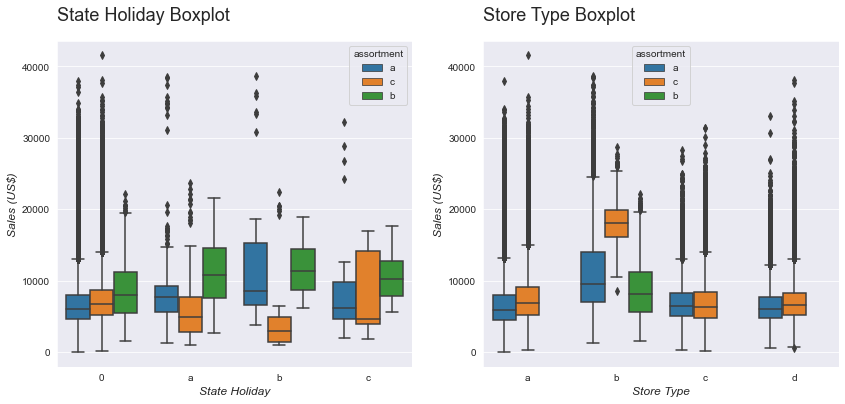

In [112]:
aux = df_ross.query('sales > 0')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(x="state_holiday", y="sales",
                  data=aux.sort_values('state_holiday'), hue='assortment')
std_font(ax1, 'State Holiday Boxplot', 'State Holiday', 'Sales (US$)')

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(x="store_type", y="sales",
                  data=aux.sort_values('store_type'), hue='assortment')
std_font(ax2, 'Store Type Boxplot', 'Store Type', 'Sales (US$)')

# 3 DATAFRAME FILTERING

## 3.1 Line Filtering

In [113]:
df_ross = df_ross.query('open == 1 and sales > 0')

## 3.2 Column Selection

In [114]:
df_ross.drop( ['open', 'promo_interval'], axis=1, inplace=True )

# 4 QUESTIONS & HYPOTHESIS

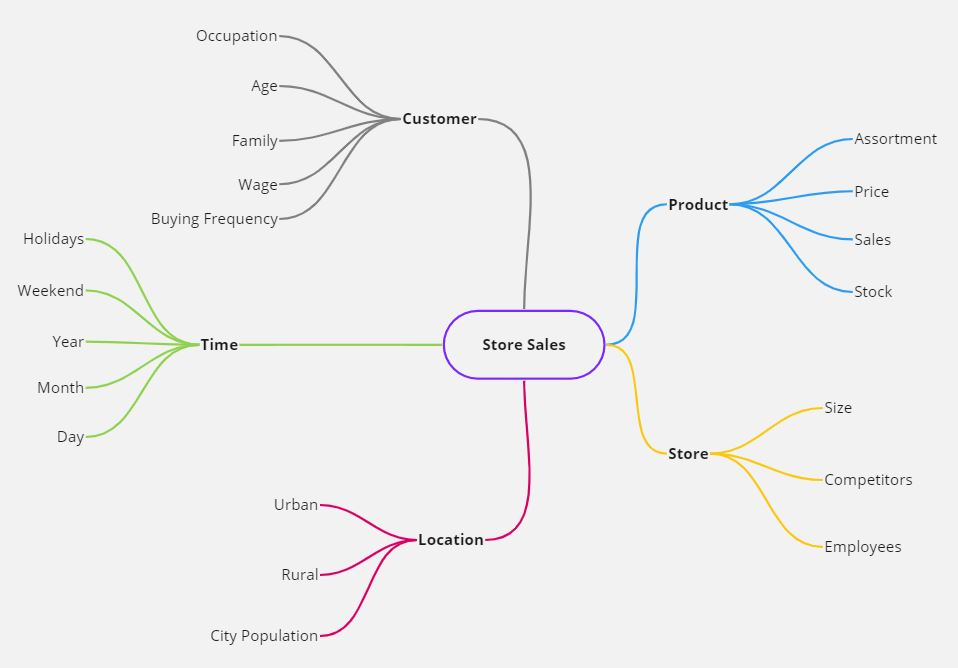

In [115]:
Image( 'mind_map.JPG' )

**1.** Statistically there is no difference in average profit between store types

**2.** On average, holidays sales are 35% higher than regular days

**3.** On average, stores with higher assortment have higher sales

**4.** On average, stores with a longer time on promo tends to sell more

**5.** A higher number of customers lead to higher sales to the store

**6.** The nearer the competitors are, the lesser is the sales.

**7.** Stores tends to sell more through the years.

**8.** On average, sales on winter are 20% less.

**9.** On average, Stores tends to sell 10% more on weekends.

**10.** On average, stores affected by school holidays sells 8% less.

# 5 FEATURE ENGINEERING

In [116]:
# Mapping the week name
week_map = {1: 'Monday',  2: 'Tuesday',  3: 'Wednesday',  4: 'Thursday',
            5: 'Friday',  6: 'Saturday',  7: 'Sunday'}
df_ross['day_of_week_name'] = df_ross['day_of_week'].map( week_map )

# year
df_ross['year'] = df_ross['date'].dt.year

# month
df_ross['month'] = df_ross['date'].dt.month

# year week
df_ross['year_week'] = df_ross['date'].dt.strftime( '%Y-%W' )

# year month
df_ross['year_month'] = df_ross['date'].dt.strftime('%Y-%m')


# error value 1900 in competition_open_since_year
"""the 1900 value can be an error in previous parsing. While parsing, the 1900-01-01T00:00:00.000 is a default value"""
df_ross['competition_open_since_year'] = df_ross.apply(year_correction, axis=1)

# assortment
df_ross['assortment'] = df_ross['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df_ross['state_holiday'] = df_ross['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a'
                                                          else 'easter_holiday' if x == 'b' 
                                                          else 'christmas' if x == 'c' 
                                                          else 'regular_day' )

# promo since
df_ross['promo2_since'] = df_ross['promo2_since_year'].astype( str ) + '-' + df_ross['promo2_since_week'].astype( str )
df_ross['promo2_since'] = df_ross['promo2_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) )
df_ross['weeks_in_promo2'] = ( ( df_ross['date'] - df_ross['promo2_since'] ) /7 ).apply( lambda x: x.days ).astype( int )


# 6 EXPLORATORY DATA ANALYSIS

## 6.1 Univariate Analysis

### 6.1.1 Response Variable

The response variable is not 100% normal distributed, since we can see little skew to the right. Might be a good idea to use some transformation before building the model. 

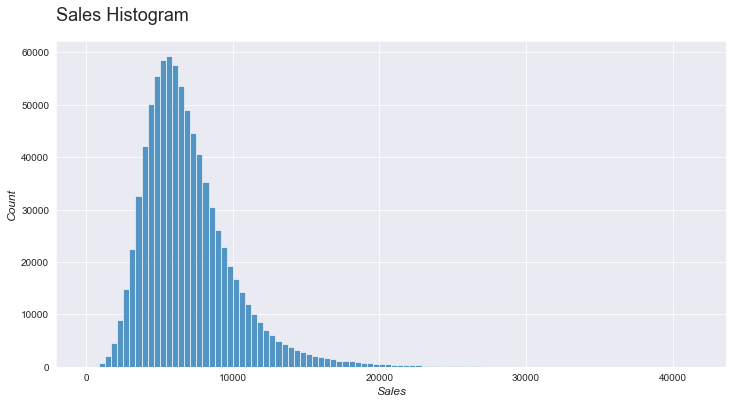

In [122]:
plt.figure(figsize=(12, 6))
ax1 = sns.histplot(df_ross['sales'], kde=False, bins=100)
std_font(ax1, 'Sales Histogram', 'Sales', 'Count')

### 6.1.2 Numerical Variable

Is important to notice that the outliers from competition_distance and promo2_sice_year are expected (we have treated them earlier).

In [118]:
num_att = df_ross.select_dtypes(['int64', 'float64', 'int32'])

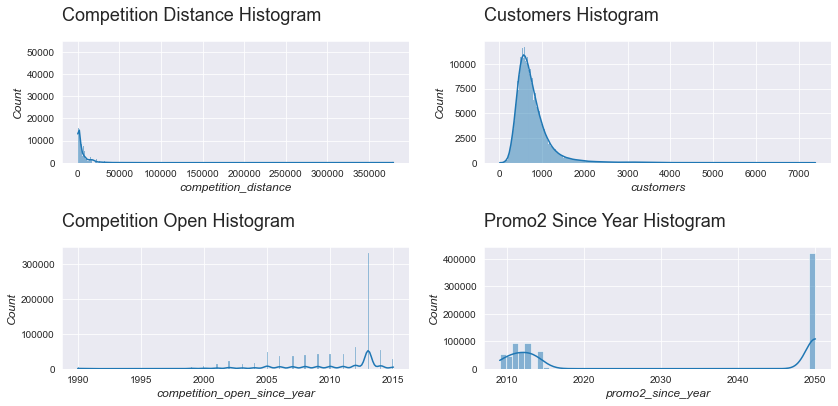

In [121]:
plt.figure(figsize=(12, 6), tight_layout={'pad': 2.0})

plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=num_att, x="competition_distance", kde=True)
std_font(ax1, 'Competition Distance Histogram',
         'competition_distance', 'Count')
plt.subplot(2, 2, 2)
ax2 = sns.histplot(data=num_att, x="customers", kde=True)
std_font(ax2, 'Customers Histogram', 'customers', 'Count')
plt.subplot(2, 2, 3)
ax3 = sns.histplot(data=num_att, x="competition_open_since_year", kde=True)
std_font(ax3, 'Competition Open Histogram',
         'competition_open_since_year', 'Count')
plt.subplot(2, 2, 4)
ax4 = sns.histplot(data=num_att, x="promo2_since_year", kde=True)
std_font(ax4, 'Promo2 Since Year Histogram', 'promo2_since_year', 'Count')

plt.show()

### 6.1.3 Categorical Variable

In [22]:
cat_att = df_ross.select_dtypes(exclude=['int64', 'float64', 'int32', 'datetime64[ns]'])

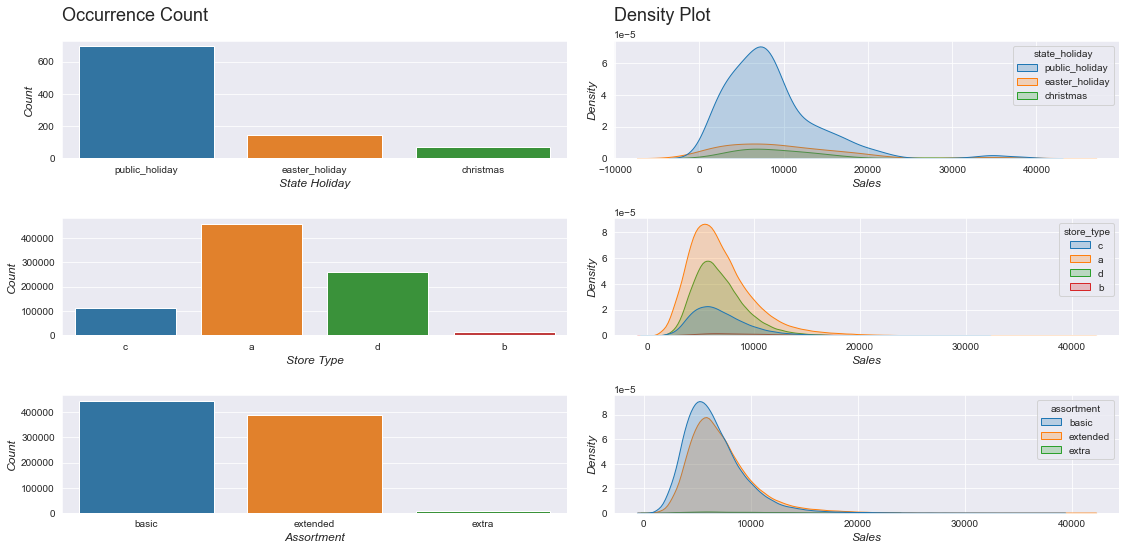

In [124]:
plt.figure(figsize=(16, 8), tight_layout={'pad':2.0})
plt.subplot( 3, 2, 1 )
a = df_ross[df_ross['state_holiday'] != 'regular_day']
ax1 = sns.countplot(x= a['state_holiday'] )
std_font(ax1, 'Occurrence Count',
         'State Holiday', 'Count')

plt.subplot( 3, 2, 2 )
ax2 = sns.kdeplot( data=a, x='sales', hue='state_holiday', shade=True )
std_font(ax2, 'Density Plot',
         'Sales', 'Density')

# store_type
plt.subplot( 3, 2, 3 )
ax3 = sns.countplot( x=df_ross['store_type'] )
std_font(ax3, '',
         'Store Type', 'Count')

plt.subplot( 3, 2, 4 )
ax4 = sns.kdeplot( data=df_ross, x='sales', hue='store_type', shade=True )
std_font(ax4, '',
         'Sales', 'Density')

# assortment
plt.subplot( 3, 2, 5 )
ax5 = sns.countplot( x=df_ross['assortment'] )
std_font(ax5, '',
         'Assortment', 'Count')

plt.subplot( 3, 2, 6 )
ax6 = sns.kdeplot( data=df_ross, x='sales', hue='assortment', shade=True )
std_font(ax6, '',
         'Sales', 'Density')


## 6.2 Bivariate Analysis

### Statistically there is no difference in average profit between store types

**FALSE** - There is a huge difference in average profit between the type b and the others. With the hypotesis tests made, with a 95% level of confidence, we can affirm that the average profit of store type 'a' and 'c' are the same. While all others are different.


P-value of the test1 (comparing a with c):  0.4855

P-value of the test2 (comparing a with d):  0.0

P-value of the test3 (comparing c with d):  0.0


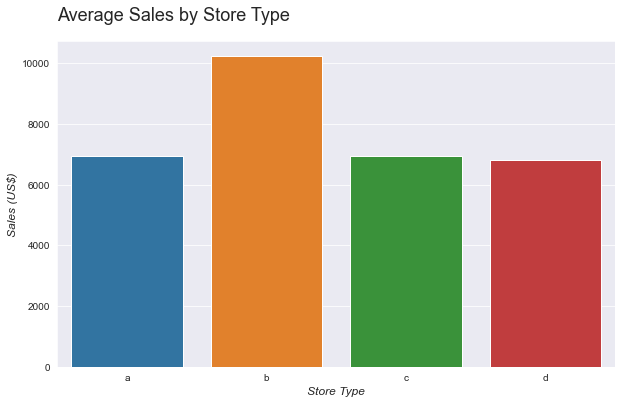

In [127]:
# aggregating features
avg_store_type = df_ross[['sales', 'store_type']].groupby('store_type').mean().reset_index()
                         

# ploting
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=avg_store_type, x='store_type', y='sales')
std_font(ax1, 'Average Sales by Store Type', 'Store Type', 'Sales (US$)')
# Creating variables to hypothesis testing
type_a = df_ross.query('store_type == "a"')['sales']
type_b = df_ross.query('store_type == "b"')['sales']
type_c = df_ross.query('store_type == "c"')['sales']
type_d = df_ross.query('store_type == "d"')['sales']

# Instancing
test_type_a = DescrStatsW(type_a)
test_type_b = DescrStatsW(type_b)
test_type_c = DescrStatsW(type_c)
test_type_d = DescrStatsW(type_d)

# Hypothesis testing
test1 = test_type_a.get_compare(test_type_c)
print('\nP-value of the test1 (comparing a with c): ',
      round(test1.ztest_ind(alternative='two-sided')[1], 4))

test2 = test_type_a.get_compare(test_type_d)
print('\nP-value of the test2 (comparing a with d): ',
      round(test2.ztest_ind(alternative='two-sided')[1], 4))

test3 = test_type_c.get_compare(test_type_d)
print('\nP-value of the test3 (comparing c with d): ',
      round(test3.ztest_ind(alternative='two-sided')[1], 4))

### On average, holidays sales are 35% higher than regular days
**TRUE** - On holidays, sales are 34.78% higher than regular days.

In [25]:
# aggregating features
sales_holidays = df_ross[['sales', 'state_holiday']].groupby('state_holiday').mean().reset_index()

display(sales_holidays)
print('Holidays sales / regular days = {}'.format(sales_holidays.iloc[0:3,1].mean() / sales_holidays.iloc[3,1]))

,state_holiday,sales
0,christmas,9743.746479
1,easter_holiday,9887.889655
2,public_holiday,8487.471182
3,regular_day,6953.960229


Holidays sales / regular days = 1.3478702010429997


### On average, stores with higher assortment have higher sales
**TRUE** - As we can see in the chart below, the higher an assortment is the higher is the store sales.

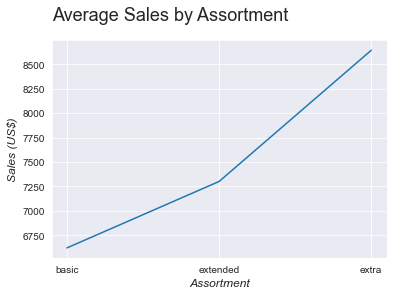

In [128]:
# aggregating features
sales_assortments = df_ross[['sales', 'assortment']].groupby('assortment').mean().reset_index()

# plotting
ax1 = sns.lineplot(data=sales_assortments, x='assortment', y='sales')
std_font(ax1, 'Average Sales by Assortment', 'Assortment', 'Sales (US$)')

### On average, stores with a longer time on promo tends to sell more
**TRUE** - There is a positive relation between the time on promo and the sales. While stores on promo tends to sell more, stores not in promo tends to keep its average sales.

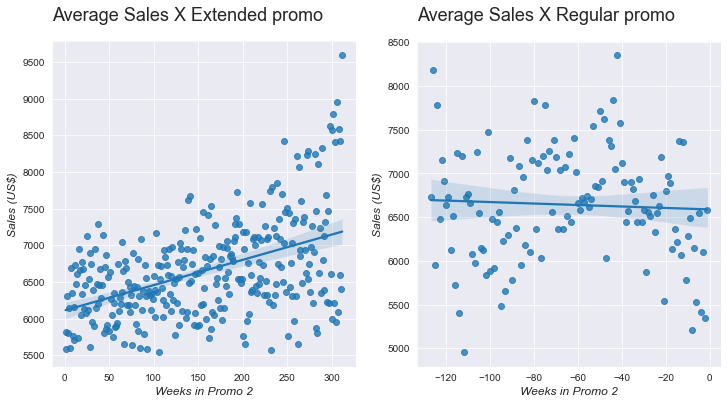

In [129]:
# aggregating features
sales_promo = df_ross[['weeks_in_promo2', 'sales']].groupby( 'weeks_in_promo2').mean().reset_index()

# plotting
plt.figure(figsize=(12, 6))
plt.subplot( 1, 2, 1 )
aux = sales_promo.query('weeks_in_promo2 > 0') # extended promo
ax1 = sns.regplot( x='weeks_in_promo2', y='sales', data=aux )
std_font(ax1, 'Average Sales X Extended promo', 'Weeks in Promo 2', 'Sales (US$)')

plt.subplot( 1, 2, 2 )
aux2 = sales_promo.query('weeks_in_promo2 < 0 and weeks_in_promo2 > -1500') # promo regular
ax2 = sns.regplot( x='weeks_in_promo2', y='sales', data=aux2 )
std_font(ax2, 'Average Sales X Regular promo', 'Weeks in Promo 2', 'Sales (US$)')


### A higher number of customers lead to higher sales to the store
**TRUE** - Customers and sales have a high correlation.

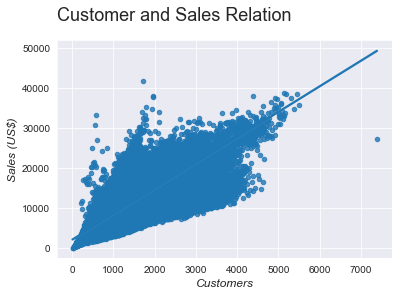

In [130]:
# plotting
ax1 = sns.regplot(data=df_ross, x='customers', y='sales', scatter_kws={"s": 20})
std_font(ax1, 'Customer and Sales Relation', 'Customers', 'Sales (US$)')

### The nearer the competitors are, the lesser is the sales.
**FALSE** - As we can see on charts below, stores with near competitors tends to sell the same (in some cases, tends to sell more) than stores with far competitors.

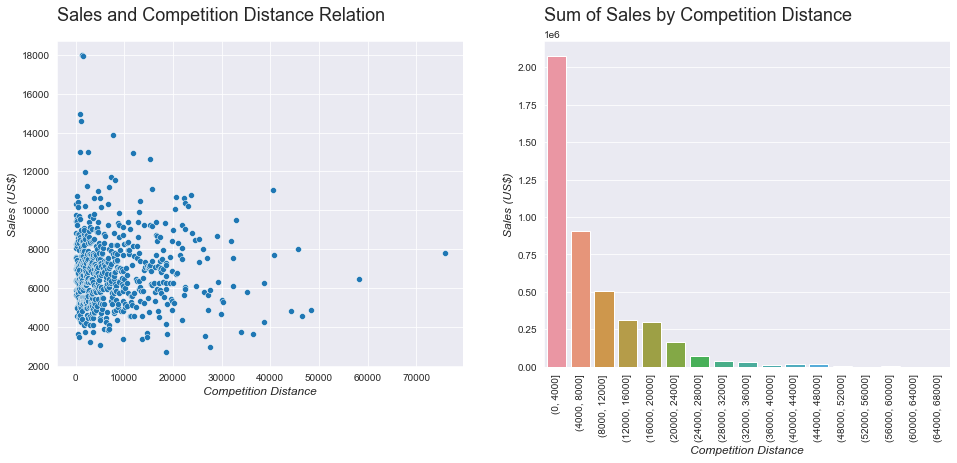

In [132]:
# aggregating features
aux1 = df_ross.query('competition_distance < 379300') # removing the value indicating absence of competition
sales_distance = aux1[['competition_distance', 'sales']].groupby( 'competition_distance' ).mean().reset_index()

# plotting
plt.figure(figsize=(16, 6))
plt.subplot( 1, 2, 1 )
ax1 = sns.scatterplot(data=sales_distance, x='competition_distance', y='sales')
std_font(ax1, 'Sales and Competition Distance Relation', 'Competition Distance', 'Sales (US$)')

plt.subplot( 1, 2, 2 )
bins = list( np.arange( 0, 70000, 4000) )
sales_distance['competition_distance_binned'] = pd.cut( sales_distance['competition_distance'], bins=bins )
sales_distance_bin = sales_distance[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
ax2 = sns.barplot( x='competition_distance_binned', y='sales', data=sales_distance_bin )
std_font(ax2, 'Sum of Sales by Competition Distance', 'Competition Distance', 'Sales (US$)')
plt.xticks( rotation=90 );

### Stores tends to sell more through the years.
**FALSE** - We noticed a slightly reduction on sales from 2013 to 2014. This trend tends to continue, even though in this dataset we do not have all data from 2015.

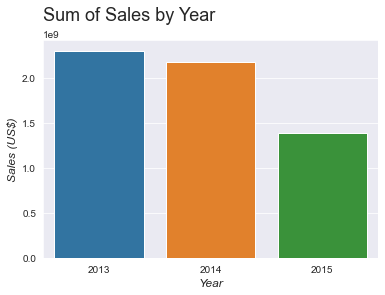

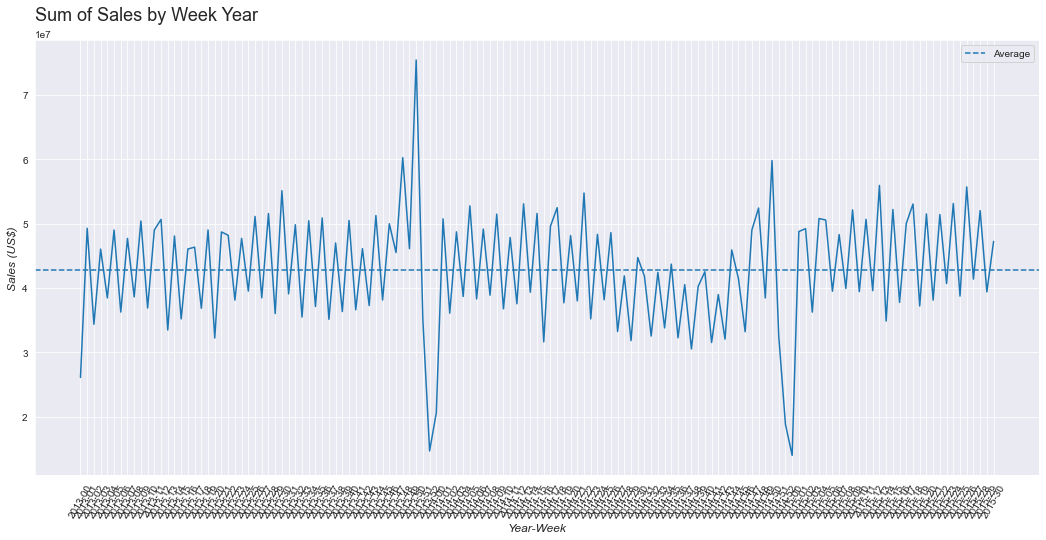

In [134]:
# aggregating features
sales_years = df_ross[['sales', 'year']].groupby('year').sum().reset_index()

sales_week = df_ross[['sales', 'year_week']].groupby('year_week').sum().reset_index()
average_sales = df_ross[['sales', 'year_week']].groupby('year_week').sum()['sales'].mean()

# Plotting
ax1 = sns.barplot(data=sales_years, x='year', y='sales')
std_font(ax1, 'Sum of Sales by Year', 'Year', 'Sales (US$)')

plt.figure( figsize=(18, 8) )
plt.axhline( average_sales, linestyle='--', label='Average')
ax2 = sns.lineplot(data=sales_week.sort_values('year_week'), x='year_week', y='sales', ci=None)
std_font(ax2, 'Sum of Sales by Week Year', 'Year-Week', 'Sales (US$)')
a = plt.xticks(rotation=60)

### On average, sales on winter are 20% less.
**FALSE** - Sales increased by 5% on winter, with the higher peak in december.

Sales on winter are 1.0549819150231277 higher, on average.


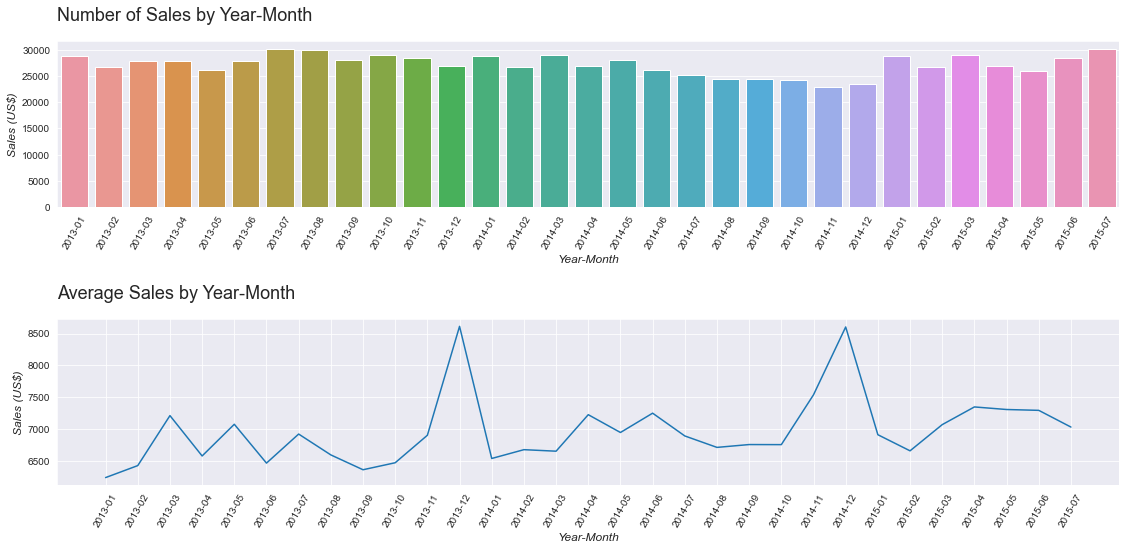

In [136]:
# Aggregating features
count_year_month = df_ross[['year_month','sales']].groupby('year_month').count().reset_index()
average_year_month = df_ross[['year_month','sales']].groupby('year_month').mean().reset_index()

# Plotting
plt.figure(figsize=(16,8), tight_layout={'pad':2.0})
plt.subplot(2,1,1)
ax1 = sns.barplot(data=count_year_month, x='year_month', y='sales')
std_font(ax1, 'Number of Sales by Year-Month', 'Year-Month', 'Sales (US$)')
a = plt.xticks(rotation=60)

plt.subplot(2,1,2)
ax2 = sns.lineplot(data=average_year_month, x='year_month', y='sales')
std_font(ax2, 'Average Sales by Year-Month', 'Year-Month', 'Sales (US$)')
a = plt.xticks(rotation=60)

# Average multiplier
sales_months = df_ross[['sales', 'month']].groupby('month').mean().reset_index()
sales_not_winter_avg = sales_months.query('month > 2 and month < 11')['sales'].mean()
sales_winter_avg = sales_months.loc[[10,11,0,1],'sales'].mean()
print('Sales on winter are {} higher, on average.'.format(sales_winter_avg / sales_not_winter_avg))

### On average, Stores tends to sell 10% more on weekends.
**FALSE** - On average sales on weekends are slightly lower than regular days. But, the days with more sales are on monday and sunday.

Average sales on regular days are 1.01773570214856 higher than sales on weekend


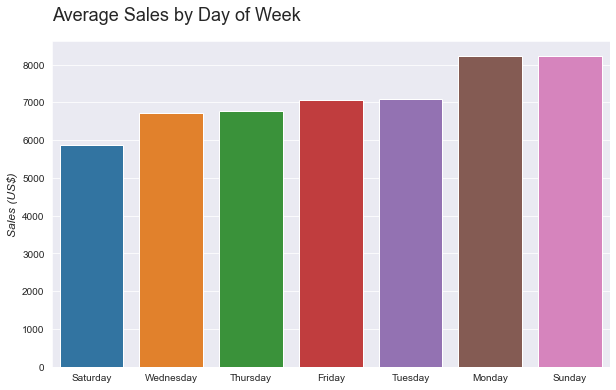

In [137]:
# aggregating features
sales_week = df_ross[['sales', 'day_of_week_name']].groupby(
    'day_of_week_name').mean().reset_index()
sales_regular_day = sales_week.loc[[0, 1, 4, 5, 6], 'sales'].mean()
sales_weekends = sales_week.loc[[2, 3], 'sales'].mean()

# plotting
print('Average sales on regular days are {} higher than sales on weekend'.format(
    sales_regular_day / sales_weekends))
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=sales_week.sort_values(
    'sales'), x='day_of_week_name', y='sales')
std_font(ax1, 'Average Sales by Day of Week', '', 'Sales (US$)')

### On average, stores affected by school holidays sells 8% less.
**FALSE** - Stores affected by school holidays sells 4% more.

Stores affected by school holidays sells 1.0440036691969854 more then not effected ones.


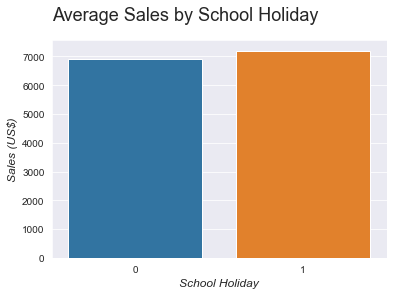

In [138]:
# aggregating features
sales_school_holidays = df_ross[['sales', 'school_holiday']].groupby(
    'school_holiday').mean().reset_index()
sales_school = sales_school_holidays.loc[0, 'sales']
sales_not_school = sales_school_holidays.loc[1, 'sales']
print('Stores affected by school holidays sells {} more then not effected ones.'.format(
    sales_not_school / sales_school))

# plotting
ax1 = sns.barplot(data=sales_school_holidays, x='school_holiday', y='sales')
std_font(ax1, 'Average Sales by School Holiday',
         'School Holiday', 'Sales (US$)')

### Hypothesis overview

In [34]:
tab =[['Hypothesis', 'Conclusion', 'Relevance', 'Discover'],
      ['H1', 'False', 'Medium', 'Store type b is quite different form others.'],  
      ['H2', 'True', 'High', 'On holidays, sales are 34.78% higher than regular days.'],  
      ['H3', 'True', 'High', 'Higher assortment leads to higher store sales.'],
      ['H4', 'True', 'Medium', 'Stores with longer time on promo tends to sell more.'],
      ['H5', 'True', 'Low', 'Customers and turnover have a high correlation.'],
      ['H6', 'False', 'Medium', 'Higher sales occurs more often in stores close to competitors.'],
      ['H7', 'False', 'Medium', 'Sales declined slightly throug the years.'],
      ['H8', 'False', 'Low', 'Sales increases by 5% on winter.'],
      ['H9', 'False', 'High', 'Sales on weekends are slightly lower then regular days.'],
      ['H10', 'False', 'Medium', 'Stores affected by school holidays sells 4% more.']
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance    Discover
------------  ------------  -----------  --------------------------------------------------------------
H1            False         Medium       Store type b is quite different form others.
H2            True          High         On holidays, sales are 34.78% higher than regular days.
H3            True          High         Higher assortment leads to higher store sales.
H4            True          Medium       Stores with longer time on promo tends to sell more.
H5            True          Low          Customers and turnover have a high correlation.
H6            False         Medium       Higher sales occurs more often in stores close to competitors.
H7            False         Medium       Sales declined slightly throug the years.
H8            False         Low          Sales increases by 5% on winter.
H9            False         High         Sales on weekends are slightly lower then regular days.
H10           False         Medium

## 6.3 Multivariate Analysis


### 6.3.1 Numerical Attributes

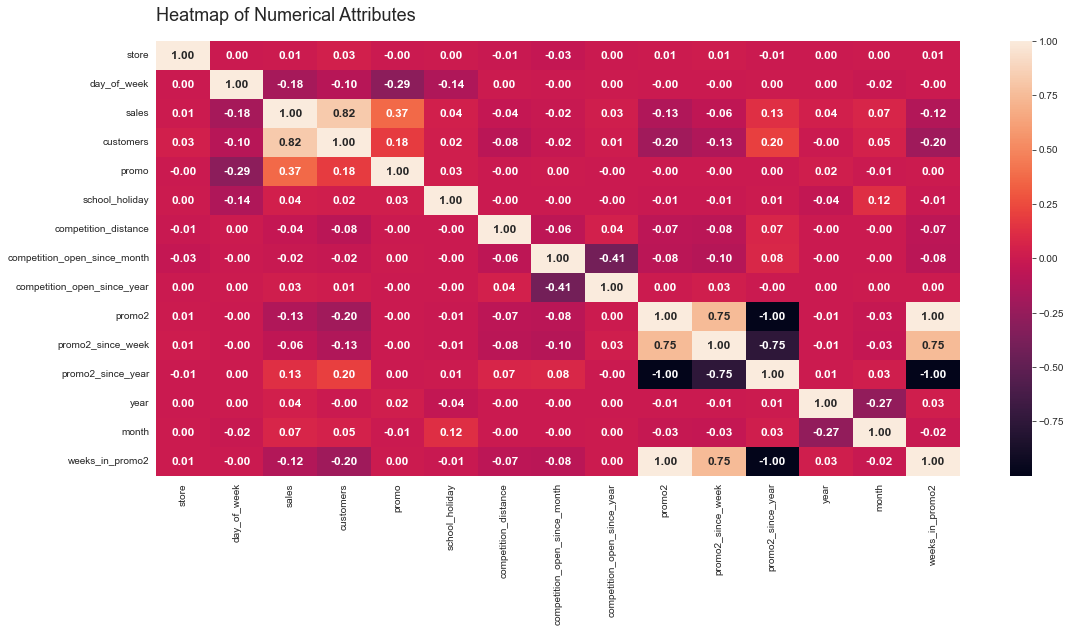

In [140]:
correlation = num_att.corr( method='pearson' )
plt.figure( figsize=(18, 8) )
ax1 = sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':12, 'fontweight':'bold'})
std_font(ax1, 'Heatmap of Numerical Attributes', '', '')

### 6.3.2 Categorical Attributes

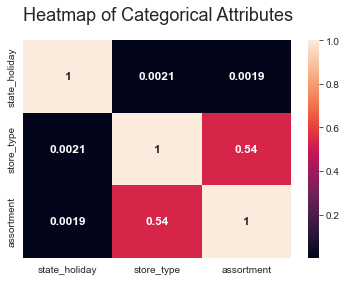

In [142]:
correlation_matrix = corr_matrix(cat_att,columns=['state_holiday','store_type','assortment'])
ax1 = sns.heatmap(data=correlation_matrix, annot=True, annot_kws={'fontsize':12, 'fontweight':'bold'})
std_font(ax1, 'Heatmap of Categorical Attributes', '', '')

# 7 DATA PREPARATION

## 7.1 Normalization

In this dataset we don't have features that are normally distributed, so we will skip this step.

## 7.2 Rescaling

In order to properly build a machine learning model, it is a good practice to put the features in the same or approximate scale. Doing so, it will improve our model training and response.

In [38]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance -> robust scaler
df_ross['competition_distance'] = rs.fit_transform( df_ross[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# year MinMax Scaler
df_ross['year'] = mms.fit_transform( df_ross[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

# weeks in promo2 -> MinMax scaler 
df_ross['weeks_in_promo2'] = mms.fit_transform( df_ross[['weeks_in_promo2']].values )
pickle.dump( mms, open( 'parameter/weeks_in_promo2_scaler.pkl', 'wb') )

## 7.3 Transformation

### 7.3.1 Encoding

In this step we create numerical features out of categorial ones. After this, our model will be able to learn from these numerical categories.

In [39]:
# state_holiday - One Hot Encoding
df_ross = pd.get_dummies(
    df_ross, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df_ross['store_type'] = le.fit_transform(df_ross['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df_ross['assortment'] = df_ross['assortment'].map(assortment_dict)

### 7.3.2 Response Variable Transformation

In section 6.1.1 we saw that our response variable have a certain skew to the right. Here we are doing a logaritmic transformation in order to improve the behavior of our variable. The objective is to make the distribution as close as possible from a normal distribution.

In [40]:
df_ross['sales'] = np.log1p( df_ross['sales'] )

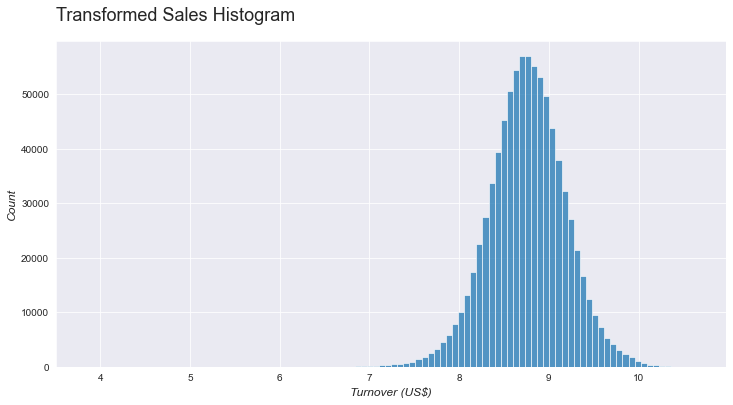

In [41]:
plt.figure(figsize=(12, 6))
ax1 = sns.histplot( df_ross['sales'], kde=False, bins=100  )
std_font(ax1, 'Transformed Sales Histogram', 'Turnover (US$)', 'Count')

### 7.3.3 Nature Transformation

this is a transformation for cyclic features.

In [42]:
# day of week
df_ross['day_of_week_sin'] = df_ross['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df_ross['day_of_week_cos'] = df_ross['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df_ross['month_sin'] = df_ross['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df_ross['month_cos'] = df_ross['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


# 8 FEATURE SELECTION

## 8.1 Split dataframe into training and test dataset

Here we are not using the standard method from sklearn to split training and test data. We are avoiding take random samples to our training and test datasets. Doing so, we will prevent the model to learn aspects from the "future". This will avoid a biased and an overfitting model.

We manually set the training and test datasets as shown below:

In [43]:
cols_drop = ['month','customers', 'day_of_week', 'day_of_week_name',
             'promo2_since', 'year_week' ]
df_ross.drop( cols_drop, axis=1, inplace=True )

In [44]:
# training dataset
X_train = df_ross[df_ross['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df_ross[df_ross['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 8.2 Boruta as Feature Selector

After all the previous analysis, we can manually select the features that will be present in our model. Manual feature selection can probably lead us to a poor model, since we are not sure which features are most important to our model. To overcome this matter we are running a Boruta method. This approach will give us a more accurate set of features that are most important to the studied phenomenon and consequently to our model.

In [45]:
# ==========================================
# COMMENTED BECAUSE IT TAKES A WHILE TO RUN
# ==========================================
# * To minimize the execution time, it is good to run it in a GPU or TPU based environment.

# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [46]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 8.3 Manual Feature Selection

Finally we have the selected features from Boruta.

In [47]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'weeks_in_promo2',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
]

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 9 MACHINE LEARNING MODELLING

In [143]:
# using the selected features from boruta to build the model
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 9.1 Average Model

In [49]:
df_ross = x_test.copy()
df_ross['sales'] = y_test.copy()

# prediction
aux2 = df_ross[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
df_ross = pd.merge( df_ross, aux2, how='left', on='store' )
yhat_baseline = df_ross['predictions']


# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) 
                                                                                             
                                                                                             
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 9.2 Linear Regression Model

In [50]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1874.035123,0.295508,2679.492888


## 9.3 Linear Regression Regularized Model - Lasso

In [51]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1895.530709,0.28714,2759.976877


## 9.4 Random Forest Regressor

In [52]:
# model
rf = RandomForestRegressor( n_estimators=100, 
                           n_jobs=-1,         
                           random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.205405,0.101608,993.752354


## 9.5 XGBoost Regressor

In [53]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',   
                              n_estimators=100,               
                              max_depth=10,                   
                              subsample=0.7,         
                            ).fit( x_train, y_train ) # Subsample ratio of columns when constructing each tree.

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,722.468221,0.105422,1052.741554


## 9.6 Compare Model's Performance

After building different models to our solution, we compare its metrics to select the best model. We will probably choose between the random forest regressor model or the XGBoost model, because they showed better results.

After these results we will run a cross-validation method to make sure our model are not overfitting and have a good generalization.

In [54]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.205405,0.101608,993.752354
0,XGBoost Regressor,722.468221,0.105422,1052.741554
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1874.035123,0.295508,2679.492888
0,Linear Regression - Lasso,1895.530709,0.287140,2759.976877


## 9.7 Linear Regression Model - Cross Validation

In [55]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2105.36 +/- 291.3,0.31 +/- 0.02,2975.66 +/- 479.35


## 9.8 Linear Regression Regularized Model - Lasso - Cross Validation

In [56]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2126.92 +/- 365.46,0.3 +/- 0.01,3056.74 +/- 547.17


## 9.9 Random Forest Regressor - Cross Validation

In [57]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,981.12 +/- 346.29,0.14 +/- 0.04,1409.5 +/- 499.37


## 9.10 XGBoost Regressor - Cross Validation

In [58]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\xgboost\data.py:262: Future

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,972.5 +/- 330.82,0.13 +/- 0.04,1412.93 +/- 498.84


## 9.11 Cross Validation Comparison

After the cross-validation method, we will choose the XGBoost Regressor because it is slightly better than the random forest regressor.

In [59]:
# Overall models results
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2105.36 +/- 291.3,0.31 +/- 0.02,2975.66 +/- 479.35
0,Lasso,2126.92 +/- 365.46,0.3 +/- 0.01,3056.74 +/- 547.17
0,Random Forest Regressor,981.12 +/- 346.29,0.14 +/- 0.04,1409.5 +/- 499.37
0,XGBoost Regressor,972.5 +/- 330.82,0.13 +/- 0.04,1412.93 +/- 498.84


# 10 HYPERPARAMETER FINE TUNNING

Now that we have selected our final model, we will try to optimize its parameters in order to enhance the model results and metrics. To do this we will run a random search hyperparameter fine tuning.


## 10.1 Random Search

In [60]:
# selecting the possible parameters to be taken
param = {
   'n_estimators': [1500, 1700, 2500, 3000, 3500],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 5 # Quantidades de iterações do tuning

In [61]:
# ===================================================================================
# COMMENTED BECAUSE IT TAKES A WHILE TO RUN AND ITS OUTPUT WAS SAVED IN A .CSV FILE
# ===================================================================================
# * To minimize the execution time, it is good to run it in a GPU or TPU based environment.

# Choosed model: XGBoost

# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
# #choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() } # .items retorna os itens (key-values) de um dicionario
#     print(hp)
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',    
#                                   n_estimators=hp['n_estimators'],       
#                                  # eta=0.01,                        
#                                   max_depth=hp['max_depth'],        
#                                   subsample=hp['subsample'],        
#                                   # colsample_bytree=0.9  
#                                  min_child_weight=hp['min_child_weight'])

#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
#     final_result = pd.concat( [final_result, result] )
# final_result

## 10.2 Final Model

In [62]:
# After  executing the random search, we saved the best parameters to our model:

param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    #eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                   # colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )


# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,689.696928,0.09898,1018.418738


# 11 ERROR INTERPRETATION

In this section we will translate the model metrics and results to a business language.

In [63]:
df_error = X_test[ cols_selected_boruta_full ]

# rescale
df_error['sales'] = np.expm1( df_error['sales'] )
df_error['predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11876\3522368099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['sales'] = np.expm1( df_error['sales'] )
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11876\3522368099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['predictions'] = np.expm1( yhat_xgb_tuned )


## 11.1 Business Performance

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,252831.656250,245429.894786,260233.417714,7401.761464,0.509347
291,292,101537.695312,98294.623625,104780.767000,3243.071687,0.493215
182,183,218846.109375,216884.541976,220807.676774,1961.567399,0.331029
549,550,253707.078125,252048.859692,255365.296558,1658.218433,0.328011
875,876,207099.093750,202885.362283,211312.825217,4213.731467,0.326465


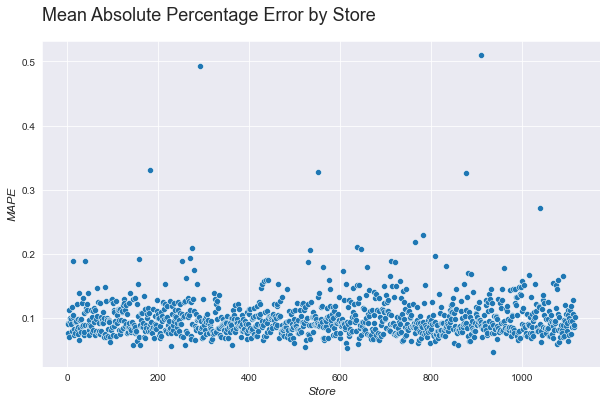

In [144]:
# sum of predictions
df_error1 = df_error[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df_error_aux1 = df_error[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df_error_aux2 = df_error[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df_error_aux3 = pd.merge( df_error_aux1, df_error_aux2, how='inner', on='store' )
df_error2 = pd.merge( df_error1, df_error_aux3, how='inner', on='store' )

# Scenarios
df_error2['worst_scenario'] = df_error2['predictions'] - df_error2['MAE']
df_error2['best_scenario'] = df_error2['predictions'] + df_error2['MAE']

# order columns
df_error2 = df_error2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

display(df_error2.sort_values( 'MAPE', ascending=False ).head())
plt.figure(figsize=(10, 6))
ax1 = sns.scatterplot( x='store', y='MAPE', data=df_error2 )
std_font(ax1, 'Mean Absolute Percentage Error by Store', 'Store', 'MAPE')

## 11.2 Overall Performance

In [65]:
df_error3 = df_error2[['predictions', 'worst_scenario', 'best_scenario']].apply(
    lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df_error3['Values'] = df_error3['Values'].map('R${:,.2f}'.format)
df_error3

,Scenario,Values
0,predictions,"R$285,424,832.00"
1,worst_scenario,"R$284,651,793.79"
2,best_scenario,"R$286,197,814.45"


## 11.3 Model Performance

In this section we will check some characteristics of our model.

**1.** The predicted value and the real values are very close to each other. The model was able to learn the tendency and seasonality of the dataset.

**2.** The residual distribution is normally distributed, which is a good indicator that our model had a good fit.

**3.** Even though we have a few high errors, most of the error values are in a closed range of values. Which is a good indicator to our model.

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11876\2913038742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['error'] = df_error['sales'] - df_error['predictions']
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11876\2913038742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['error_rate'] = df_error['predictions'] / df_error['sales']
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and

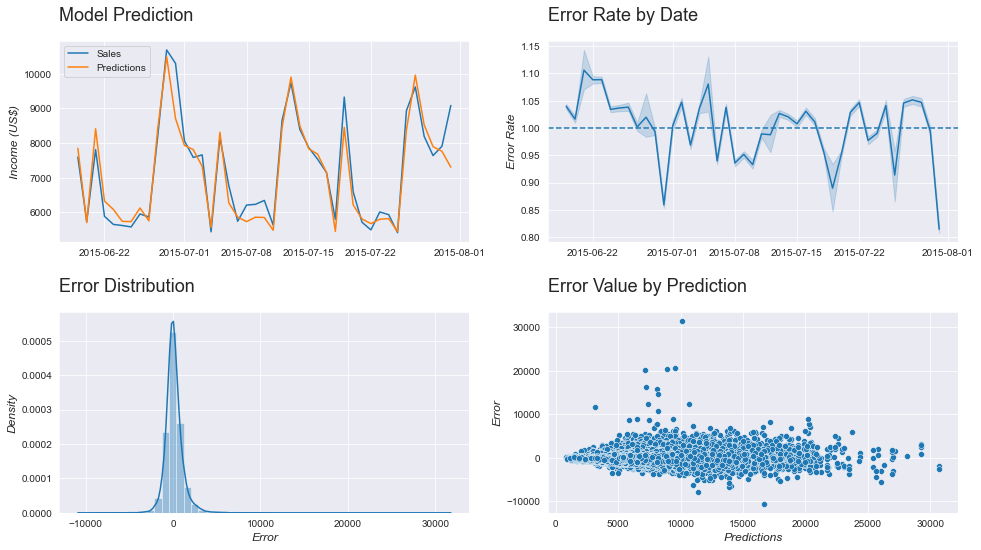

In [147]:
df_error['error'] = df_error['sales'] - df_error['predictions']
df_error['error_rate'] = df_error['predictions'] / df_error['sales']

plt.figure(figsize=(14,8), tight_layout={'pad': 2.0})
plt.subplot( 2, 2, 1 )
ax1 = sns.lineplot( x='date', y='sales', data=df_error, label='Sales', ci=None )
sns.lineplot( x='date', y='predictions', data=df_error, label='Predictions', ci=None )
std_font(ax1, 'Model Prediction', '', 'Income (US$)')

plt.subplot( 2, 2, 2 )
ax2 = sns.lineplot( x='date', y='error_rate', data=df_error )
std_font(ax2, 'Error Rate by Date', '', 'Error Rate')
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
ax3 = sns.distplot( df_error['error'] )
std_font(ax3, 'Error Distribution', 'Error', 'Density')

plt.subplot( 2, 2, 4 )
ax4 = sns.scatterplot( df_error['predictions'], df_error['error'] )
std_font(ax4, 'Error Value by Prediction', 'Predictions', 'Error')

# SAVING MODEL TO DEPLOY

In [67]:
# Saving trained model
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pkl', 'wb' ) )

objects = []
with (open('model/model_rossmann.pkl', "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
objects

[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)]